In [1]:
!python -V

Python 3.11.2


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [8]:
import mlflow


mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/Users/karoryba/Documents/projects/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1718810611746, experiment_id='1', last_update_time=1718810611746, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [9]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [11]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

/Users/karoryba/.pyenv/versions/3.11.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.838799799829628

/var/folders/zm/8d4z5ycj3_v18kv6_r4rm3k40000gn/T/ipykernel_95267/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/var/folders/zm/8d4z5ycj3_v18kv6_r4rm3k40000gn/T/ipykernel_95267/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, lab

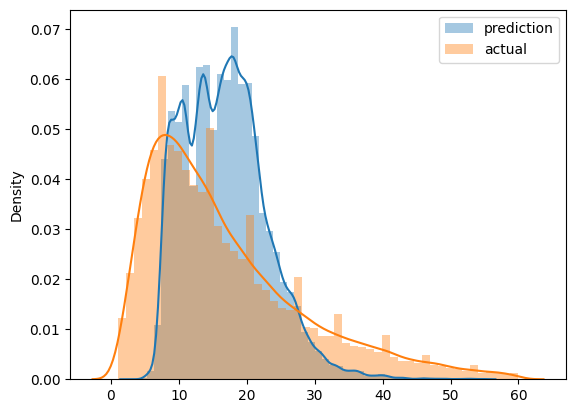

In [12]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [13]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [14]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [15]:
len(df_train), len(df_val)

(73908, 61921)

In [16]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [18]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [19]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [20]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/Users/karoryba/.pyenv/versions/3.11.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.758715200888857

In [22]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [26]:
with mlflow.start_run():

    mlflow.set_tag("developer", "karolina")

    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.parquet")
    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse=mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

/Users/karoryba/.pyenv/versions/3.11.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [28]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [32]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [35]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [36]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/Users/karoryba/.pyenv/versions/3.11.2/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [11:58:29] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.17515                           
[1]	validation-rmse:7.04599                           
[2]	validation-rmse:6.74464                           
[3]	validation-rmse:6.64308                           
[4]	validation-rmse:6.60200                           
[5]	validation-rmse:6.58277                           
[6]	validation-rmse:6.57234                           
[7]	validation-rmse:6.56580                           
[8]	validation-rmse:6.56109                           
[9]	validation-rmse:6.55677                           
[10]	validation-rmse:6.55230                          
[11]	validation-rmse:6.54988                          
[12]	validation-rmse:6.54538                          
[13]	validation-rmse:6.54577                          
[14]	validation-rmse:6.53955                          
[15]	validation-rmse:6.53760                          
[16]	validation-rmse:6.53026                          
[17]	validation-rmse:6.52593                          
[18]	valid

/Users/karoryba/.pyenv/versions/3.11.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/karoryba/.pyenv/versions/3.11.2/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [11:59:05] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.91385                                                    
[1]	validation-rmse:7.52213                                                    
[2]	validation-rmse:6.98021                                                    
[3]	validation-rmse:6.76571                                                    
[4]	validation-rmse:6.66152                                                    
[5]	validation-rmse:6.61184                                                    
[6]	validation-rmse:6.58357                                                    
[7]	validation-rmse:6.57119                                                    
[8]	validation-rmse:6.56475                                                    
[9]	validation-rmse:6.56099                                                    
[10]	validation-rmse:6.55526                                                   
[11]	validation-rmse:6.54991                                                   
[12]	validation-rmse:6.54584            

/Users/karoryba/.pyenv/versions/3.11.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/karoryba/.pyenv/versions/3.11.2/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [11:59:34] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.61021                                                   
[1]	validation-rmse:11.06691                                                   
[2]	validation-rmse:10.57832                                                   
[3]	validation-rmse:10.14011                                                   
[4]	validation-rmse:9.74789                                                    
[5]	validation-rmse:9.39779                                                    
[6]	validation-rmse:9.08590                                                    
[7]	validation-rmse:8.80853                                                    
[8]	validation-rmse:8.56248                                                    
[9]	validation-rmse:8.34448                                                    
[10]	validation-rmse:8.15211                                                   
[11]	validation-rmse:7.98237                                                   
[12]	validation-rmse:7.83194            

/Users/karoryba/.pyenv/versions/3.11.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/karoryba/.pyenv/versions/3.11.2/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:01:46] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.73256                                                      
[1]	validation-rmse:6.89368                                                      
[2]	validation-rmse:6.72965                                                      
[3]	validation-rmse:6.68390                                                      
[4]	validation-rmse:6.66780                                                      
[5]	validation-rmse:6.66092                                                      
[6]	validation-rmse:6.64765                                                      
[7]	validation-rmse:6.64507                                                      
[8]	validation-rmse:6.64085                                                      
[9]	validation-rmse:6.63092                                                      
[10]	validation-rmse:6.62155                                                     
[11]	validation-rmse:6.61441                                                     
[12]	validation-

/Users/karoryba/.pyenv/versions/3.11.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/karoryba/.pyenv/versions/3.11.2/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:02:11] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.70229                                                   
[1]	validation-rmse:11.23245                                                   
[2]	validation-rmse:10.80060                                                   
[3]	validation-rmse:10.40488                                                   
[4]	validation-rmse:10.04257                                                   
[5]	validation-rmse:9.71116                                                    
[6]	validation-rmse:9.40929                                                    
[7]	validation-rmse:9.13395                                                    
[8]	validation-rmse:8.88247                                                    
[9]	validation-rmse:8.65382                                                    
[10]	validation-rmse:8.44627                                                   
[11]	validation-rmse:8.25881                                                   
[12]	validation-rmse:8.08867            

/Users/karoryba/.pyenv/versions/3.11.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/karoryba/.pyenv/versions/3.11.2/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:05:19] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.96950                                                      
[1]	validation-rmse:9.98465                                                       
[2]	validation-rmse:9.21175                                                       
[3]	validation-rmse:8.61177                                                       
[4]	validation-rmse:8.15152                                                       
[5]	validation-rmse:7.80096                                                       
[6]	validation-rmse:7.53404                                                       
[7]	validation-rmse:7.33270                                                       
[8]	validation-rmse:7.18093                                                       
[9]	validation-rmse:7.06633                                                       
[10]	validation-rmse:6.97921                                                      
[11]	validation-rmse:6.91184                                                      
[12]

/Users/karoryba/.pyenv/versions/3.11.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/karoryba/.pyenv/versions/3.11.2/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:06:22] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.67892                                                     
[1]	validation-rmse:11.19185                                                     
[2]	validation-rmse:10.74779                                                     
[3]	validation-rmse:10.34397                                                     
[4]	validation-rmse:9.97727                                                      
[5]	validation-rmse:9.64541                                                      
[6]	validation-rmse:9.34451                                                      
[7]	validation-rmse:9.07356                                                      
[8]	validation-rmse:8.82830                                                      
[9]	validation-rmse:8.60890                                                      
[10]	validation-rmse:8.41138                                                     
[11]	validation-rmse:8.23367                                                     
[12]	validation-

/Users/karoryba/.pyenv/versions/3.11.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/karoryba/.pyenv/versions/3.11.2/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:07:19] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.16824                                                   
[1]	validation-rmse:8.83532                                                    
[2]	validation-rmse:7.99426                                                    
[3]	validation-rmse:7.47721                                                    
[4]	validation-rmse:7.15903                                                    
[5]	validation-rmse:6.96434                                                    
[6]	validation-rmse:6.83986                                                    
[7]	validation-rmse:6.76236                                                    
[8]	validation-rmse:6.70733                                                    
[9]	validation-rmse:6.67174                                                    
[10]	validation-rmse:6.64822                                                   
[11]	validation-rmse:6.62952                                                   
[12]	validation-rmse:6.61672            

/Users/karoryba/.pyenv/versions/3.11.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/karoryba/.pyenv/versions/3.11.2/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:08:06] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.60757                                                    
[1]	validation-rmse:6.74610                                                    
[2]	validation-rmse:6.57149                                                    
[3]	validation-rmse:6.51582                                                    
[4]	validation-rmse:6.49378                                                    
[5]	validation-rmse:6.48209                                                    
[6]	validation-rmse:6.47544                                                    
[7]	validation-rmse:6.46868                                                    
[8]	validation-rmse:6.46178                                                    
[9]	validation-rmse:6.45311                                                    
[10]	validation-rmse:6.44582                                                   
[11]	validation-rmse:6.44232                                                   
[12]	validation-rmse:6.43775            

/Users/karoryba/.pyenv/versions/3.11.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/karoryba/.pyenv/versions/3.11.2/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:08:26] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.04729                                                    
[1]	validation-rmse:6.91066                                                    
[2]	validation-rmse:6.61606                                                    
[3]	validation-rmse:6.51593                                                    
[4]	validation-rmse:6.47490                                                    
[5]	validation-rmse:6.45169                                                    
[6]	validation-rmse:6.43900                                                    
[7]	validation-rmse:6.43314                                                    
[8]	validation-rmse:6.42836                                                    
[9]	validation-rmse:6.42311                                                    
[10]	validation-rmse:6.41841                                                   
[11]	validation-rmse:6.41293                                                   
[12]	validation-rmse:6.40794            

KeyboardInterrupt: 

In [ ]:
mlflow.xgboost.autolog(disable=True)

In [37]:
with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

/Users/karoryba/.pyenv/versions/3.11.2/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [14:08:23] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.44482
[1]	validation-rmse:10.77202
[2]	validation-rmse:10.18363
[3]	validation-rmse:9.67396
[4]	validation-rmse:9.23166
[5]	validation-rmse:8.84808
[6]	validation-rmse:8.51883
[7]	validation-rmse:8.23597
[8]	validation-rmse:7.99320
[9]	validation-rmse:7.78709
[10]	validation-rmse:7.61022
[11]	validation-rmse:7.45952
[12]	validation-rmse:7.33049
[13]	validation-rmse:7.22098
[14]	validation-rmse:7.12713
[15]	validation-rmse:7.04752
[16]	validation-rmse:6.98005
[17]	validation-rmse:6.92232
[18]	validation-rmse:6.87112
[19]	validation-rmse:6.82740
[20]	validation-rmse:6.78995
[21]	validation-rmse:6.75792
[22]	validation-rmse:6.72994
[23]	validation-rmse:6.70547
[24]	validation-rmse:6.68390
[25]	validation-rmse:6.66421
[26]	validation-rmse:6.64806
[27]	validation-rmse:6.63280
[28]	validation-rmse:6.61924
[29]	validation-rmse:6.60773
[30]	validation-rmse:6.59777
[31]	validation-rmse:6.58875
[32]	validation-rmse:6.58107
[33]	validation-rmse:6.57217
[34]	validation-rmse:

/Users/karoryba/.pyenv/versions/3.11.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/karoryba/.pyenv/versions/3.11.2/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [14:09:47] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
python(39503) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [39]:

logged_model = 'runs:/0c98b0e1de9445dead8d1b6ebe7662c0/models_mlflow'

# Load model as a Spark UDF.
loaded_model = mlflow.pyfunc.load_model(logged_model)

/Users/karoryba/.pyenv/versions/3.11.2/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [14:27:36] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [40]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 0c98b0e1de9445dead8d1b6ebe7662c0

In [42]:
xgboost_model = mlflow.xgboost.load_model(logged_model)

/Users/karoryba/.pyenv/versions/3.11.2/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [14:28:57] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [43]:
y_pred = xgboost_model.predict(valid)

In [44]:
y_pred[:10]

array([14.782765 ,  7.184751 , 15.971323 , 24.328938 ,  9.559302 ,
       17.115105 , 11.6522455,  8.688133 ,  8.962229 , 18.982166 ],
      dtype=float32)